In [1]:
import os
import cv2
import shutil
import numpy as np
from sklearn.model_selection import train_test_split
import random
import subprocess
from IPython.display import Image, display
import glob

In [2]:
%cd /kaggle/working/yolov9/

/kaggle/working/yolov9


In [ ]:
# dataset_path = '/kaggle/working/dataset'
# yolov9_path = '/kaggle/working/yolov9'

# if os.path.exists(dataset_path):
#     shutil.rmtree(dataset_path)

# if os.path.exists(yolov9_path):
#     shutil.rmtree(yolov9_path)

In [ ]:
!git clone https://github.com/WongKinYiu/yolov9.git
%cd yolov9
!pip install -r requirements.txt

In [ ]:
!mkdir -p /kaggle/working/yolov9/weights
!wget -P /kaggle/working/yolov9/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/yolov9-c.pt
!wget -P /kaggle/working/yolov9/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/yolov9-e.pt
!wget -P /kaggle/working/yolov9/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/gelan-c.pt
!wget -P /kaggle/working/yolov9/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/gelan-e.pt

In [ ]:
pip install opencv-python-headless

In [ ]:
dataset_dir = '/kaggle/input/bee-classification'
output_dir = '/kaggle/working/dataset'

In [ ]:
def copy_dataset(src_dir, dest_dir):
    if not os.path.exists(dest_dir):
        os.makedirs(dest_dir)
    for item in os.listdir(src_dir):
        s = os.path.join(src_dir, item)
        d = os.path.join(dest_dir, item)
        if os.path.isdir(s):
            copy_dataset(s, d)
        else:
            shutil.copy2(s, d)

In [ ]:
src_images_dir = os.path.join(dataset_dir, 'images')
src_labels_dir = os.path.join(dataset_dir, 'labels')
dest_images_dir = os.path.join(output_dir, 'images')
dest_labels_dir = os.path.join(output_dir, 'labels')

copy_dataset(src_images_dir, dest_images_dir)
copy_dataset(src_labels_dir, dest_labels_dir)

In [ ]:
def validate_label_line(line, num_classes=4):
    parts = line.strip().split()
    if len(parts) != 5:
        return False
    try:
        class_id, x_center, y_center, width, height = map(float, parts)
        if not 0 <= class_id < num_classes:
            return False
        if not all(0.0 <= val <= 1.0 for val in [x_center, y_center, width, height]):
            return False
    except ValueError:
        return False
    return True

def correct_labels_in_directory(labels_dir, images_dir):
    for label_file in os.listdir(labels_dir):
        if not label_file.endswith('.txt'):
            continue
        
        label_path = os.path.join(labels_dir, label_file)
        with open(label_path, 'r') as file:
            lines = file.readlines()
        
        if not all(validate_label_line(line) for line in lines):
            os.remove(label_path)
            
            image_file = label_file.replace('.txt', '.jpg') 
            image_path = os.path.join(images_dir, image_file)
            if os.path.exists(image_path):
                os.remove(image_path)
            print(f"Deleted {label_file} and {image_file} due to format issues.")

correct_labels_in_directory(dest_labels_dir, dest_images_dir)

In [ ]:
def fix_image_dimensions(images_dir, expected_size=(640, 640)):
    fixed_images = 0

    image_files = [f for f in os.listdir(images_dir) if f.endswith(('.jpg', '.png'))]

    for image_file in image_files:
        image_path = os.path.join(images_dir, image_file)
        try:
            image = cv2.imread(image_path)
            if image is None:
                continue
            
            h, w = image.shape[:2]
            if (w, h) != expected_size:
                resized_image = cv2.resize(image, expected_size)
                cv2.imwrite(image_path, resized_image)
                fixed_images += 1
                print(f"Resized {image_path} from {image.shape[:2]} to {expected_size}")
        except Exception as e:
            print(f"Error fixing dimensions for {image_path}: {e}")

    print(f"Total images fixed: {fixed_images}")

fix_image_dimensions(dest_images_dir)

In [ ]:
images_dir = dest_images_dir
labels_dir = dest_labels_dir

def check_label_format(label_path):
    with open(label_path, 'r') as file:
        lines = file.readlines()
        for line in lines:
            parts = line.strip().split()
            if len(parts) != 5:
                return False
    return True

def check_image_dimensions(image_path, expected_size=(640, 640)):
    try:
        image = cv2.imread(image_path)
        if image is None:
            return False
        h, w = image.shape[:2]
        return (w, h) == expected_size
    except Exception as e:
        print(f"Error checking dimensions for {image_path}: {e}")
        return False

def summarize_dataset_checks(images_dir, labels_dir):
    label_issues, image_dim_issues = 0, 0

    image_files = [f for f in os.listdir(images_dir) if f.endswith(('.jpg', '.png'))]
    label_files = [f for f in os.listdir(labels_dir) if f.endswith('.txt')]

    for label_file in label_files:
        label_path = os.path.join(labels_dir, label_file)
        if not check_label_format(label_path):
            label_issues += 1

    for image_file in image_files:
        image_path = os.path.join(images_dir, image_file)
        if not check_image_dimensions(image_path):
            image_dim_issues += 1

    print(f"Total label format issues: {label_issues}")
    print(f"Total image dimension issues: {image_dim_issues}")

summarize_dataset_checks(images_dir, labels_dir)


In [ ]:
splits = ['train', 'val', 'test']
for split in splits:
    os.makedirs(os.path.join(output_dir, split, 'images'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, split, 'labels'), exist_ok=True)

In [ ]:
filenames = [os.path.splitext(f)[0] for f in os.listdir(images_dir) if not f.startswith('.')]

In [ ]:
train_dir = "/kaggle/working/dataset/train";
val_dir = "/kaggle/working/dataset/val";
test_dir = "/kaggle/working/dataset/test";

In [ ]:
train_files, val_test_files = train_test_split(filenames, test_size=0.3, random_state=42)
val_files, test_files = train_test_split(val_test_files, test_size=(1/3), random_state=42)

In [ ]:
def copy_files(files, split):
    for filename in files:
        shutil.copy(os.path.join(images_dir, filename + '.jpg'), os.path.join(output_dir, split, 'images', filename + '.jpg'))
        shutil.copy(os.path.join(labels_dir, filename + '.txt'), os.path.join(output_dir, split, 'labels', filename + '.txt'))

In [ ]:
copy_files(train_files, 'train')
copy_files(val_files, 'val')
copy_files(test_files, 'test')

In [ ]:
import yaml
import os

data_yaml_path = '/kaggle/working/dataset/data.yaml'

data_yaml = {
    'train': '../dataset/train/images',
    'val': '../dataset/val/images',
    'test': '../dataset/test/images',
    'nc': 4,
    'names': ['Worker Bee', 'Drone Bee', 'Hornet', 'Wasp']
}

with open(data_yaml_path, 'w') as file:
    yaml.dump(data_yaml, file, default_flow_style=False)

print("data.yaml updated successfully.")


In [ ]:
!python train.py \
--batch 16 --epochs 50 --img 640 --min-items 0 --close-mosaic 15 \
--data /kaggle/working/dataset/data.yaml \
--weights /kaggle/working/yolov9/weights/gelan-c.pt \
--cfg /kaggle/working/yolov9/models/detect/gelan-c.yaml \
--hyp /kaggle/working/yolov9/data/hyps/hyp.scratch-high.yaml

In [ ]:
!python train.py \
--batch 16 --epochs 100 --img 640 --min-items 0 --close-mosaic 15 \
--data /kaggle/working/dataset/data.yaml \
--weights /kaggle/working/yolov9/runs/train/exp/weights/last.pt \
--cfg /kaggle/working/yolov9/models/detect/gelan-c.yaml \
--hyp /kaggle/working/yolov9/data/hyps/hyp.scratch-high.yaml

2024-04-18 17:45:02.687532: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-18 17:45:02.687650: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-18 17:45:02.817463: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice: (30 second timeout) 
wandb: W&B disabled due to login timeout.
train: weights=/kaggle/working/yolov9/runs/train/exp/weights/last.pt, cfg=/kaggle/working/yolov9/models/detect/gelan-c.yaml, data=/kaggle/working/dataset/data.yaml, hy

In [ ]:
shutil.rmtree('/kaggle/working/yolov9/runs/detect')

In [ ]:
os.listdir('/kaggle/working/yolov9/runs/train/exp')

In [ ]:
!python val.py --weights /kaggle/working/yolov9/runs/train/exp/weights/best.pt --data /kaggle/working/dataset/data.yaml --img 640 --conf-thres 0.5 --iou-thres 0.5 --task test

detect: weights=['/kaggle/working/yolov9/runs/train/exp4/weights/best.pt'], source=/kaggle/working/dataset/test/images/Vespa-velutina_aguillot_cc-by-nc_182320369_0_jpeg.rf.a7e8d2811559e786506ebb2771732723.jpg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.5, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLO 🚀 v0.1-76-g519346b Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)

Fusing layers... 
gelan-c summary: 387 layers, 25230172 parameters, 0 gradients
image 1/1 /kaggle/working/dataset/test/images/Vespa-velutina_aguillot_cc-by-nc_182320369_0_jpeg.rf.a7e8d2811559e786506ebb2771732723.jpg: 640x640 1 Hornet, 24.3ms
Speed: 0.5ms pre-process, 24.3ms inference, 324.9ms NMS per im

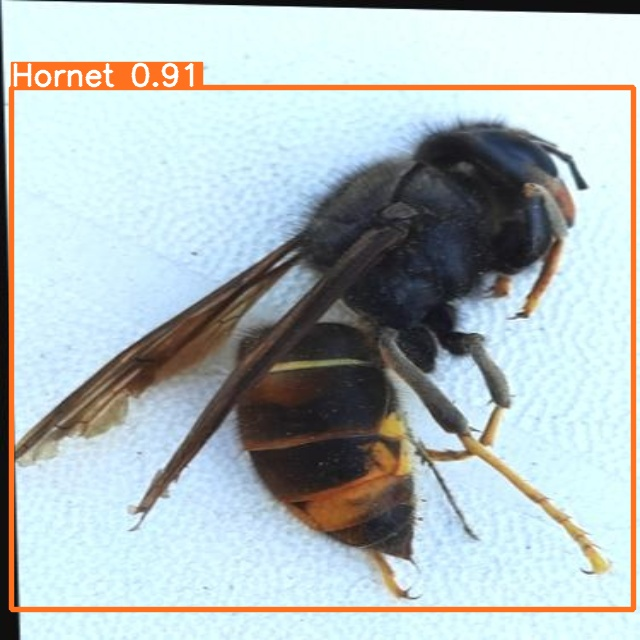

In [7]:
def get_random_image(image_dir):
    images = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
    if images:
        return os.path.join(image_dir, random.choice(images))
    else:
        return ""

test_dir = "/kaggle/working/dataset/test/images"
random_image_path = get_random_image(test_dir)
command = f"python detect.py --weights /kaggle/working/yolov9/runs/train/exp4/weights/best.pt --img 640 --conf 0.5 --source '{random_image_path}'"
subprocess.run(command, shell=True, check=True)

latest_exp_dir = max(glob.glob(os.path.join('/kaggle/working/yolov9/runs/detect', 'exp*')), key=os.path.getmtime)

output_images = glob.glob(os.path.join(latest_exp_dir, '*.jpg'))
if output_images:
    detected_image_path = output_images[0]
    display(Image(filename=detected_image_path))
else:
    print("No detected images found.")